## Amazon Stock ML

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import torch
import torch.nn as nn
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler


data = yf.Ticker('AMZN').history(period='20y', interval="1d")[['Close', 'Open', 'High','Low','Volume']]
data

,Close,Open,High,Low,Volume
Date,,,,,
2004-03-22 00:00:00-05:00,2.042500,2.087500,2.092500,2.025500,179502000
2004-03-23 00:00:00-05:00,2.011500,2.066000,2.087000,1.992500,224514000
2004-03-24 00:00:00-05:00,1.981500,2.015500,2.019000,1.957500,157518000
2004-03-25 00:00:00-05:00,2.099500,2.000000,2.110000,2.000000,142254000
2004-03-26 00:00:00-05:00,2.085000,2.100500,2.124500,2.064500,114808000
...,...,...,...,...,...
2024-03-13 00:00:00-04:00,176.559998,175.899994,177.619995,175.550003,30772600
2024-03-14 00:00:00-04:00,178.750000,177.690002,179.529999,176.470001,43705800
2024-03-15 00:00:00-04:00,174.419998,176.639999,177.929993,173.899994,72115500


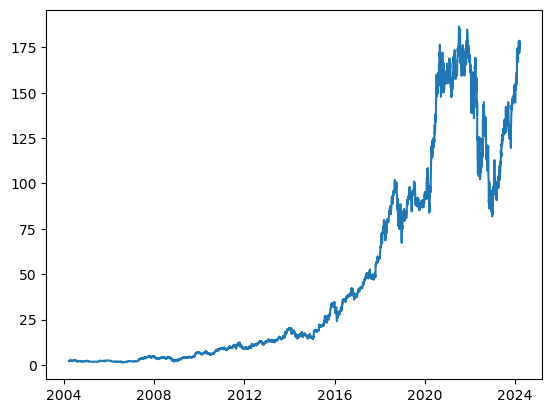

In [20]:
data = data[['Close']]
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
plt.plot(data['Close'])

In [21]:
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2004-03-31 00:00:00-05:00,2.164000,2.190000,2.138000,2.085000,2.099500,1.981500,2.011500,2.042500
2004-04-01 00:00:00-05:00,2.237000,2.164000,2.190000,2.138000,2.085000,2.099500,1.981500,2.011500
2004-04-02 00:00:00-05:00,2.304500,2.237000,2.164000,2.190000,2.138000,2.085000,2.099500,1.981500
2004-04-05 00:00:00-04:00,2.348000,2.304500,2.237000,2.164000,2.190000,2.138000,2.085000,2.099500
2004-04-06 00:00:00-04:00,2.322000,2.348000,2.304500,2.237000,2.164000,2.190000,2.138000,2.085000
...,...,...,...,...,...,...,...,...
2024-03-13 00:00:00-04:00,176.559998,175.389999,171.960007,175.350006,176.820007,173.509995,174.119995,177.580002
2024-03-14 00:00:00-04:00,178.750000,176.559998,175.389999,171.960007,175.350006,176.820007,173.509995,174.119995
2024-03-15 00:00:00-04:00,174.419998,178.750000,176.559998,175.389999,171.960007,175.350006,176.820007,173.509995


In [24]:
shifted_df_as_np = shifted_df.to_numpy()
shifted_df_as_np.shape

(5026, 8)

In [27]:
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((5026, 7), (5026,))

In [29]:
X = dc(np.flip(X, axis=1))
split_index = int(len(X) * 0.95)
split_index

4774

In [31]:
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))
y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

In [32]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [33]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [34]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [36]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [37]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [38]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [39]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 1.016
Batch 200, Loss: 0.409

Val Loss: 0.073
***************************************************

Epoch: 2
Batch 100, Loss: 0.017
Batch 200, Loss: 0.015

Val Loss: 0.030
***************************************************

Epoch: 3
Batch 100, Loss: 0.009
Batch 200, Loss: 0.009

Val Loss: 0.016
***************************************************

Epoch: 4
Batch 100, Loss: 0.004
Batch 200, Loss: 0.004

Val Loss: 0.010
***************************************************

Epoch: 5
Batch 100, Loss: 0.002
Batch 200, Loss: 0.002

Val Loss: 0.007
***************************************************

Epoch: 6
Batch 100, Loss: 0.002
Batch 200, Loss: 0.002

Val Loss: 0.006
***************************************************

Epoch: 7
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001

Val Loss: 0.004
***************************************************

Epoch: 8
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001

Val Loss: 0.004
***************************************************



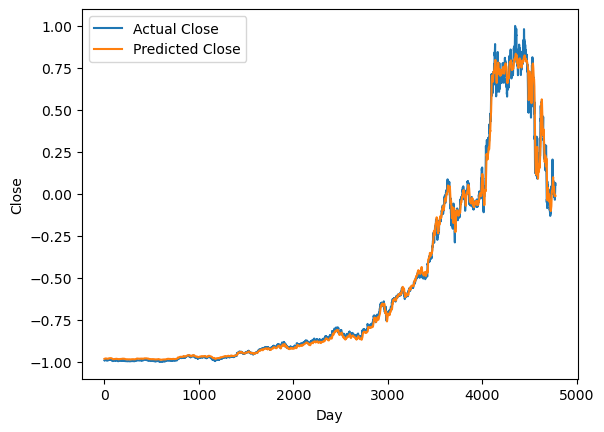

In [40]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [41]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([-0.98178941, -0.98170382, -0.98149091, ..., -0.01086617,
       -0.01250666, -0.01238796])

In [42]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([-0.99071068, -0.98992264, -0.98919398, ...,  0.0244296 ,
        0.06588333,  0.05411648])

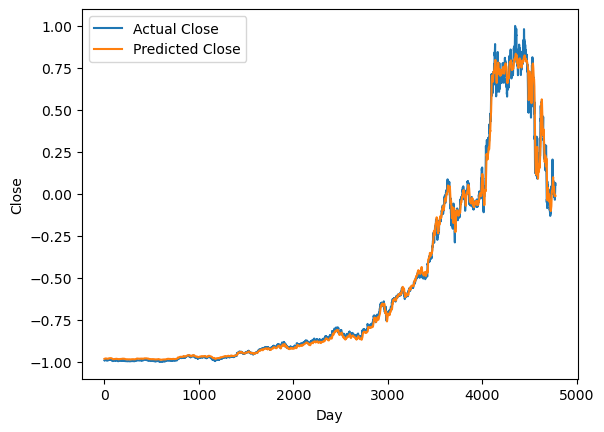

In [43]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [44]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([-0.01364523, -0.00808254,  0.00767112,  0.02255213,  0.03274748,
        0.04239807,  0.03850982,  0.03701469,  0.04200947,  0.03617671,
        0.0371426 ,  0.03861406,  0.04385987,  0.0506722 ,  0.06470901,
        0.07152361,  0.07321116,  0.0689306 ,  0.06827644,  0.05964077,
        0.06069323,  0.05832991,  0.05434862,  0.05777958,  0.07430983,
        0.0774779 ,  0.0806883 ,  0.08438441,  0.09341615,  0.09599397,
        0.10203683,  0.0967654 ,  0.09088099,  0.09923148,  0.10300174,
        0.08603695,  0.08044142,  0.08930993,  0.09573409,  0.10454942,
        0.11630118,  0.12605423,  0.13980901,  0.15789136,  0.16731028,
        0.17007393,  0.18211918,  0.19547437,  0.20355067,  0.20899375,
        0.20538127,  0.20800352,  0.21816483,  0.23334578,  0.24564482,
        0.27196565,  0.28002641,  0.2849068 ,  0.29555374,  0.30252022,
        0.30578712,  0.30600408,  0.29943103,  0.31353077,  0.31782526,
        0.3265937 ,  0.32888317,  0.3310999 ,  0.33342585,  0.33

In [45]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([0.04073042, 0.07203661, 0.05141767, 0.05152565, 0.0452644 ,
       0.04429287, 0.03565665, 0.06815032, 0.08704197, 0.10096782,
       0.09146805, 0.10809264, 0.07732625, 0.08768966, 0.08887714,
       0.06458787, 0.04202588, 0.09136008, 0.09254756, 0.09503042,
       0.09028057, 0.11187103, 0.10658132, 0.1405863 , 0.13248989,
       0.09319525, 0.11921179, 0.17146067, 0.12428548, 0.08758176,
       0.10463817, 0.10485411, 0.10863243, 0.12655255, 0.12838772,
       0.13691597, 0.17545494, 0.19693743, 0.1762106 , 0.18635806,
       0.21010762, 0.23277758, 0.26138496, 0.24087401, 0.22748795,
       0.227272  , 0.24627163, 0.22737998, 0.2825436 , 0.29927626,
       0.28761739, 0.31125888, 0.32723585, 0.33857089, 0.3527126 ,
       0.29463428, 0.32723585, 0.31838378, 0.3522808 , 0.35325241,
       0.35066149, 0.35811022, 0.34062192, 0.34375256, 0.33349711,
       0.39092764, 0.38207564, 0.3604852 , 0.38045627, 0.37894493,
       0.36663848, 0.39319474, 0.3916834 , 0.39341068, 0.37160

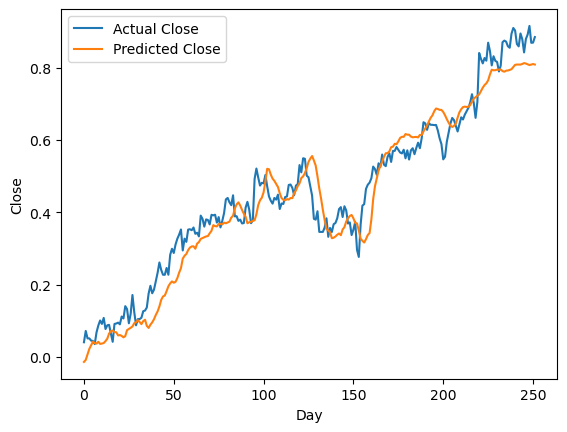

In [46]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [ ]:
# Credit by Edoardo Alberto Donolato